# Global clustering across NaV channels (multi-CSV) + UMAP & violin/bar summaries

**Goal:** Select multiple `alphaOnly` CSVs (different NaV channels), concatenate them, cluster **once** in a shared feature space (states ± PLDDTs), visualize a global **UMAP (2D)** colored by cluster, and summarize:
- **Violin plots** per state-like feature (VSDI, VSDII, VSDIII, VSDIV, IFM, SF, AG1×AG2), split by cluster.
- **Bar plot**: for each **cluster**, the **percentage** of models contributed by each **channel**.

**Algorithms supported:**
- **GMM (Gaussian Mixture)** with **BIC**-based model selection for *k* ∈ [2..6] (recommended default).
- **KMeans** with either fixed *k* or **silhouette** selection in [2..6].
- **HDBSCAN** (optional) — learns number of clusters, labels noise as `-1`.
- **Leiden** (optional) — community detection on a kNN graph (requires `igraph`, `leidenalg`).

**Install (as needed):**
```bash
pip install pandas numpy scipy scikit-learn umap-learn matplotlib seaborn
# optional:
pip install hdbscan igraph leidenalg


In [1]:
from __future__ import annotations
from pathlib import Path
import re
from typing import List, Optional, Tuple, Dict

import numpy as np
import pandas as pd

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# UMAP
try:
    try:
        from umap import UMAP
    except Exception:
        from umap.umap_ import UMAP
except Exception:
    raise ImportError("UMAP is required. Install with: pip install umap-learn")

# Optional clusterers
try:
    import hdbscan
    HAS_HDBSCAN = True
except Exception:
    HAS_HDBSCAN = False

try:
    import igraph as ig
    import leidenalg as la
    HAS_LEIDEN = True
except Exception:
    HAS_LEIDEN = False

# --- Matplotlib style for big print-ready figures ---
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.titlesize": 22,
    "axes.labelsize": 22,
    "xtick.labelsize": 19,
    "ytick.labelsize": 19,
    "legend.fontsize": 18,
    "font.size": 20,
    "axes.linewidth": 1.5,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
})

RANDOM_STATE = 42
DATA_DIR = Path("data")

STATE_COLS = ["VSDI","VSDII","VSDIII","VSDIV","AG1","AG2","IFM","SF"]
PLDDT_COLS = ["plddt full","plddt VSDI","plddt VSDII","plddt VSDIII",
              "plddt VSDIV","plddt AG","plddt IFM","plddt SF"]

def banner(msg: str) -> None:
    print("\n" + "-"*100 + f"\n{msg}\n" + "-"*100)

def list_alpha_only_csvs(root: Path) -> List[Path]:
    return sorted([p for p in root.glob("*.csv") if "alphaOnly" in p.name or "alphaonly" in p.name])

# parse recycle number from filename
_RECYCLE_PATTS = [
    re.compile(r"[._-]r(\d+)\.pdb$", re.IGNORECASE),
    re.compile(r"recycle\s*(\d+)", re.IGNORECASE),
]
def parse_recycle_from_filename(fname: str) -> Optional[int]:
    for patt in _RECYCLE_PATTS:
        m = patt.search(fname)
        if m:
            try:
                return int(m.group(1))
            except Exception:
                return None
    return None

def coerce_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def prepare_features(df: pd.DataFrame, cols: List[str]) -> np.ndarray:
    """Impute (median) + standardize."""
    X = df[cols].copy()
    imp = SimpleImputer(strategy="median")
    scl = StandardScaler()
    X_imp = imp.fit_transform(X)
    X_std = scl.fit_transform(X_imp)
    return X_std

# Multi-select indices like "0,1,2" or "0-3" or "0,2,5-7"
def parse_index_spec(spec: str, n: int) -> List[int]:
    spec = spec.replace(" ", "")
    if not spec:
        raise ValueError("Empty selection spec.")
    out = []
    for tok in spec.split(","):
        if "-" in tok:
            a,b = tok.split("-",1)
            a,b = int(a), int(b)
            if a>b: a,b = b,a
            out.extend(range(a,b+1))
        else:
            out.append(int(tok))
    # bounds + unique while preserving order
    seen = set(); clean=[]
    for i in out:
        if i<0 or i>=n:
            raise IndexError(f"Index {i} out of range (0..{n-1}).")
        if i not in seen:
            seen.add(i); clean.append(i)
    return clean

# --- Clustering backends ---
def gmm_with_bic(X: np.ndarray, k_range=range(2,7), random_state=RANDOM_STATE) -> Tuple[np.ndarray, int, Dict[int,float]]:
    best_k, best_bic, best_labels = None, np.inf, None
    bic_map = {}
    for k in k_range:
        gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=random_state, n_init=3)
        gmm.fit(X)
        bic = gmm.bic(X)
        bic_map[k] = bic
        if bic < best_bic:
            best_bic, best_k = bic, k
            best_labels = gmm.predict(X)
    return best_labels, int(best_k), bic_map

def kmeans_select(X: np.ndarray, k_mode: str = "silhouette", k: int = 3,
                  k_range=range(2,7), random_state=RANDOM_STATE) -> Tuple[np.ndarray, int, Dict[int,float]]:
    scores = {}
    if k_mode == "fixed":
        km = KMeans(n_clusters=int(k), n_init=20, random_state=random_state)
        labels = km.fit_predict(X)
        return labels, int(k), {"fixed_k": k}
    elif k_mode == "silhouette":
        best_k, best_s, best_labels = None, -np.inf, None
        for kk in k_range:
            km = KMeans(n_clusters=kk, n_init=20, random_state=random_state)
            labels = km.fit_predict(X)
            s = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else -np.inf
            scores[kk] = s
            if s > best_s:
                best_k, best_s, best_labels = kk, s, labels
        return best_labels, int(best_k), scores
    else:
        raise ValueError("k_mode must be 'fixed' or 'silhouette'.")

def hdbscan_labels(X: np.ndarray) -> Tuple[np.ndarray, int]:
    if not HAS_HDBSCAN:
        raise ImportError("hdbscan not installed. pip install hdbscan")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=None)
    labels = clusterer.fit_predict(X)
    k = len(np.unique(labels[labels >= 0]))
    return labels, int(k)

def leiden_labels(X: np.ndarray, k_neighbors: int = 15, resolution: float = 1.0) -> Tuple[np.ndarray, int]:
    if not HAS_LEIDEN:
        raise ImportError("leidenalg/igraph not installed. pip install igraph leidenalg")
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(X)
    dists, inds = nbrs.kneighbors(X)
    n = X.shape[0]
    edges = []
    for i in range(n):
        for j in inds[i, 1:]:
            edges.append((i, int(j)))
    g = ig.Graph(n=n, edges=edges, directed=False)
    part = la.find_partition(g, la.RBConfigurationVertexPartition, resolution_parameter=resolution)
    labels = np.array(part.membership, dtype=int)
    k = len(np.unique(labels))
    return labels, int(k)

def run_umap(X: np.ndarray, n_neighbors: int = 15, min_dist: float = 0.1,
             metric: str = "euclidean", random_state: int = RANDOM_STATE) -> np.ndarray:
    um = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist,
              metric=metric, random_state=random_state)
    return um.fit_transform(X)

/Users/dlopezmateos/anaconda3/envs/nav-analytics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Choose files, recycles, and feature set

- **SELECTED_SPEC**: comma/range indices of the `alphaOnly` CSVs to include (e.g., `"0-5,8"`).
- **INCLUDE_RECYCLES**: keep only these recycle numbers (e.g., `[0]` or `list(range(0,7))`).
- **FEATURE_CHOICE**: `"states"`, `"plddt"`, or `"states+plddt"` (or a custom comma list).


In [2]:
alpha_csvs = list_alpha_only_csvs(DATA_DIR)
if not alpha_csvs:
    raise FileNotFoundError(f"No *alphaOnly* CSVs found under {DATA_DIR.resolve()}")

print("Discovered alphaOnly CSVs:")
for i, p in enumerate(alpha_csvs):
    print(f"{i:2d}: {p.name}")

# --- EDIT THESE ---
SELECTED_SPEC = "0-8"                 # e.g., "0,2,5-7"  or just "0"
INCLUDE_RECYCLES = list(range(1,7))   # e.g., [0] or range(0,7)
FEATURE_CHOICE = "states+plddt"       # "states" | "plddt" | "states+plddt" | custom comma list

SELECTED_IDXS = parse_index_spec(SELECTED_SPEC, len(alpha_csvs))
SELECTED_PATHS = [alpha_csvs[i] for i in SELECTED_IDXS]
banner(f"Selected {len(SELECTED_PATHS)} CSV(s): " + ", ".join(p.name for p in SELECTED_PATHS))

# Decide features
if FEATURE_CHOICE.lower() == "states":
    FEATURES = STATE_COLS.copy()
elif FEATURE_CHOICE.lower() == "plddt":
    FEATURES = PLDDT_COLS.copy()
elif FEATURE_CHOICE.lower() in ("states+plddt","plddt+states"):
    FEATURES = STATE_COLS + PLDDT_COLS
else:
    FEATURES = [c.strip() for c in FEATURE_CHOICE.split(",") if c.strip()]

print("Features to use:")
for c in FEATURES:
    print("  -", c)


Discovered alphaOnly CSVs:
 0: NaV1.1-alphaOnly.csv
 1: NaV1.2-alphaOnly.csv
 2: NaV1.3-alphaOnly.csv
 3: NaV1.4-alphaOnly.csv
 4: NaV1.5-alphaOnly.csv
 5: NaV1.6-alphaOnly.csv
 6: NaV1.7-alphaOnly.csv
 7: NaV1.8-alphaOnly.csv
 8: NaV1.9-alphaOnly.csv
 9: NaX-alphaOnly.csv

----------------------------------------------------------------------------------------------------
Selected 9 CSV(s): NaV1.1-alphaOnly.csv, NaV1.2-alphaOnly.csv, NaV1.3-alphaOnly.csv, NaV1.4-alphaOnly.csv, NaV1.5-alphaOnly.csv, NaV1.6-alphaOnly.csv, NaV1.7-alphaOnly.csv, NaV1.8-alphaOnly.csv, NaV1.9-alphaOnly.csv
----------------------------------------------------------------------------------------------------
Features to use:
  - VSDI
  - VSDII
  - VSDIII
  - VSDIV
  - AG1
  - AG2
  - IFM
  - SF
  - plddt full
  - plddt VSDI
  - plddt VSDII
  - plddt VSDIII
  - plddt VSDIV
  - plddt AG
  - plddt IFM
  - plddt SF


Load, concatenate, normalize (shared feature space) 

In [3]:
# Helper to derive a clean channel name from filename (CSV name)
def derive_channel_name(csv_path: Path) -> str:
    # Use stem before '-alphaOnly' if present, else the stem itself
    stem = csv_path.stem
    return stem.replace("-alphaOnly","").replace("_alphaOnly","")

frames = []
for p in SELECTED_PATHS:
    df_i = pd.read_csv(p)
    # check 'filename' and chosen features exist
    if "filename" not in df_i.columns:
        raise KeyError(f"{p.name} lacks 'filename'")
    missing = [c for c in FEATURES if c not in df_i.columns]
    if missing:
        raise KeyError(f"{p.name} missing feature(s): {missing}")

    # parse recycle
    df_i["recycle"] = df_i["filename"].astype(str).apply(parse_recycle_from_filename)
    df_i = df_i[df_i["recycle"].isin(INCLUDE_RECYCLES)].copy()
    if df_i.empty:
        print(f"[WARN] {p.name}: no rows after recycle filter; skipping.")
        continue

    # add channel
    df_i["channel"] = derive_channel_name(p)

    frames.append(df_i)

if not frames:
    raise RuntimeError("No data available after filtering. Check recycles/selection.")

# Concatenate
df_all = pd.concat(frames, ignore_index=True)

# Coerce numeric (features + recycle)
df_all = coerce_numeric(df_all, FEATURES + ["recycle"])

banner(f"Combined dataset: {len(df_all)} rows from {len(frames)} CSV(s).")
df_all[["channel","recycle"] + FEATURES].head()



----------------------------------------------------------------------------------------------------
Combined dataset: 5400 rows from 9 CSV(s).
----------------------------------------------------------------------------------------------------


,channel,recycle,VSDI,VSDII,VSDIII,VSDIV,AG1,AG2,IFM,SF,plddt full,plddt VSDI,plddt VSDII,plddt VSDIII,plddt VSDIV,plddt AG,plddt IFM,plddt SF
0,NaV1.1,5.0,15.363779,15.188851,19.250141,20.446462,14.338848,12.566847,28.116965,9.467323,77.562444,78.830261,83.501721,80.014275,80.85640,78.816667,47.623333,87.197273
1,NaV1.1,6.0,15.584515,15.808267,21.057750,19.692510,14.186518,12.727038,8.099582,10.028941,73.960606,72.937130,80.651803,76.514198,74.34472,71.532500,52.240000,82.891818
2,NaV1.1,5.0,15.255886,14.685718,19.775721,19.920057,14.109031,13.311449,28.732017,10.064447,71.989469,70.985391,77.593033,71.540534,74.56960,65.981667,46.790000,83.384545
3,NaV1.1,4.0,15.657117,15.383427,19.313676,19.557090,12.913772,12.113282,28.289383,9.456067,78.384575,79.106348,84.837459,80.999389,80.53736,77.859167,47.916667,86.929545
4,NaV1.1,2.0,15.449621,14.856945,19.710943,20.111873,13.927024,13.611703,29.527255,9.896565,72.074881,72.570783,76.229180,73.016870,75.64032,63.162500,41.376667,82.297727


## 2) Global clustering across all selected channels + UMAP

Pick `CLUSTER_ALGO` and its selector:
- `"gmm"` → BIC picks k in `GMM_K_RANGE`
- `"kmeans"` → choose `K_MODE = "silhouette"` or `"fixed"` and `K_FIXED`
- `"hdbscan"` or `"leiden"` if installed

We standardize features globally before clustering and UMAP.


In [4]:
# --- EDIT THESE IF NEEDED ---
CLUSTER_ALGO = "leiden"          # "gmm" | "kmeans" | "hdbscan" | "leiden"
GMM_K_RANGE = range(2,6)

K_MODE   = "silhouette"       # for kmeans: "silhouette" or "fixed"
K_FIXED  = 4                  # used only if K_MODE=="fixed"
K_RANGE  = range(2,7)

LEIDEN_KNN = 500
LEIDEN_RES = 0.5

# Prepare features
X = prepare_features(df_all, FEATURES)

# Cluster
if CLUSTER_ALGO == "gmm":
    labels, n_clusters, score_map = gmm_with_bic(X, k_range=GMM_K_RANGE, random_state=RANDOM_STATE)
    algo_desc = f"GMM (BIC) with k={n_clusters}, BICs={score_map}"
elif CLUSTER_ALGO == "kmeans":
    labels, n_clusters, score_map = kmeans_select(X, k_mode=K_MODE, k=K_FIXED, k_range=K_RANGE, random_state=RANDOM_STATE)
    algo_desc = f"KMeans ({K_MODE}) with k={n_clusters}, scores={score_map}"
elif CLUSTER_ALGO == "hdbscan":
    labels, n_clusters = hdbscan_labels(X)
    score_map = {}
    algo_desc = f"HDBSCAN with {n_clusters} clusters (noise=-1)"
elif CLUSTER_ALGO == "leiden":
    labels, n_clusters = leiden_labels(X, k_neighbors=LEIDEN_KNN, resolution=LEIDEN_RES)
    score_map = {}
    algo_desc = f"Leiden (kNN={LEIDEN_KNN}, res={LEIDEN_RES}) with k={n_clusters}"
else:
    raise ValueError("Unknown CLUSTER_ALGO.")

df_all["cluster"] = np.asarray(labels, dtype=int)
# --- Optional: Remap cluster labels for interpretability ---
remap = {3: 0, 0: 1, 1: 2, 2: 3, 4: 4}  # old → new
df_all["cluster"] = df_all["cluster"].map(remap).astype(int)
clusters_sorted = np.sort(df_all["cluster"].unique())
banner(f"Clustering finished: {algo_desc}")

# UMAP for 2D viz (same standardized X)
emb = run_umap(X, n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=RANDOM_STATE)
df_all["UMAP1"] = emb[:,0]
df_all["UMAP2"] = emb[:,1]

# Palettes: clusters & channels
clusters_sorted = np.sort(df_all["cluster"].unique())
cluster_palette = sns.color_palette("tab10", max(10, len(clusters_sorted)))
cluster_colors = {cl: cluster_palette[i % len(cluster_palette)] for i, cl in enumerate(clusters_sorted)}

channels_sorted = np.sort(df_all["channel"].unique())
channel_palette = sns.color_palette("tab20", max(10, len(channels_sorted)))
channel_colors = {ch: channel_palette[i % len(channel_palette)] for i, ch in enumerate(channels_sorted)}



----------------------------------------------------------------------------------------------------
Clustering finished: Leiden (kNN=500, res=0.5) with k=5
----------------------------------------------------------------------------------------------------


/Users/dlopezmateos/anaconda3/envs/nav-analytics/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


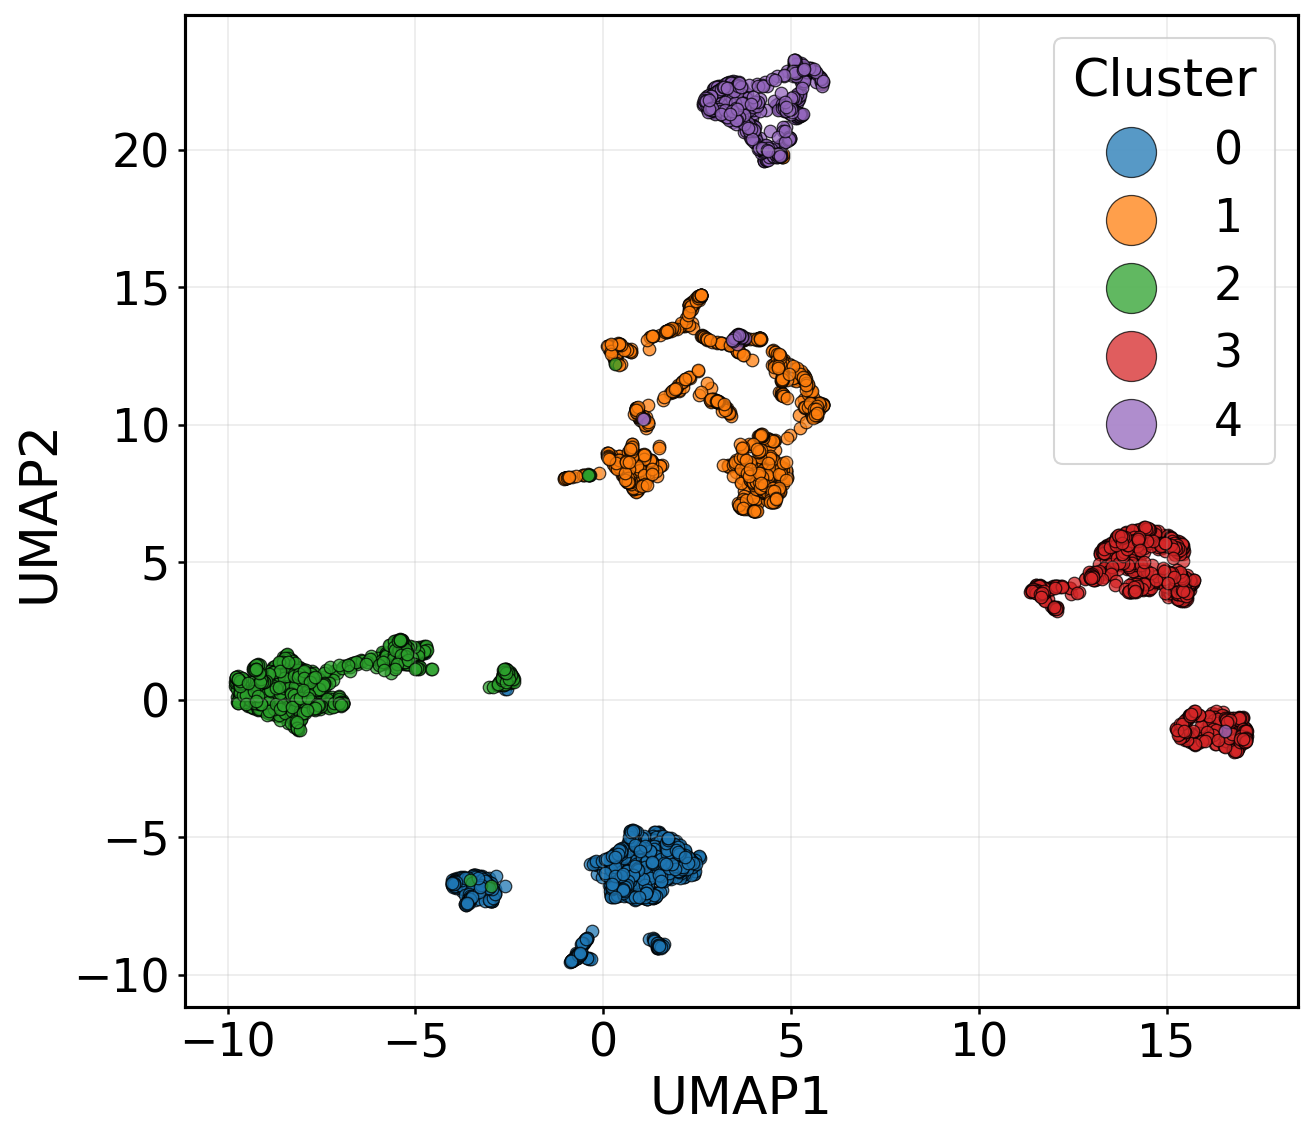


----------------------------------------------------------------------------------------------------
Saved UMAP figure to: /Users/dlopezmateos/Desktop/JGP-Nav-paper/Revision/New-analysis/Analysis1/AlphaOnly/umap_global_clusters.png
----------------------------------------------------------------------------------------------------


In [5]:
fig, ax = plt.subplots(figsize=(10.5, 8))

for cl in clusters_sorted:
    sub = df_all[df_all["cluster"] == cl]
    ax.scatter(sub["UMAP1"], sub["UMAP2"],
               s=36, edgecolor="black", linewidth=0.6,
               facecolor=cluster_colors[cl], alpha=0.75, label=f"{cl}")

ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
#ax.set_title(f"Global UMAP colored by cluster — {algo_desc}")
ax.grid(True, alpha=0.25)
ax.legend(title="Cluster", bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0.)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('UMAP1', fontsize=25)
plt.ylabel('UMAP2', fontsize=25)
plt.tight_layout()
out_umap = Path("umap_global_clusters.png")
plt.legend(title='Cluster', fontsize=22, title_fontsize=25,markerscale=4)
plt.savefig(out_umap, bbox_inches="tight")
plt.show()

banner(f"Saved UMAP figure to: {out_umap.resolve()}")


## 3) One big 8-panel figure: 7 violins (states) + 1 bar (cluster composition by channel) 

/var/folders/yg/k6t1j6jx32x4dnx7sz20k7b40000gr/T/ipykernel_76525/3515683834.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/yg/k6t1j6jx32x4dnx7sz20k7b40000gr/T/ipykernel_76525/3515683834.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/yg/k6t1j6jx32x4dnx7sz20k7b40000gr/T/ipykernel_76525/3515683834.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/yg/k6t1j6jx32x4dnx7sz20k7b40000gr/T/ipykernel_76525/3515683834.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is dep

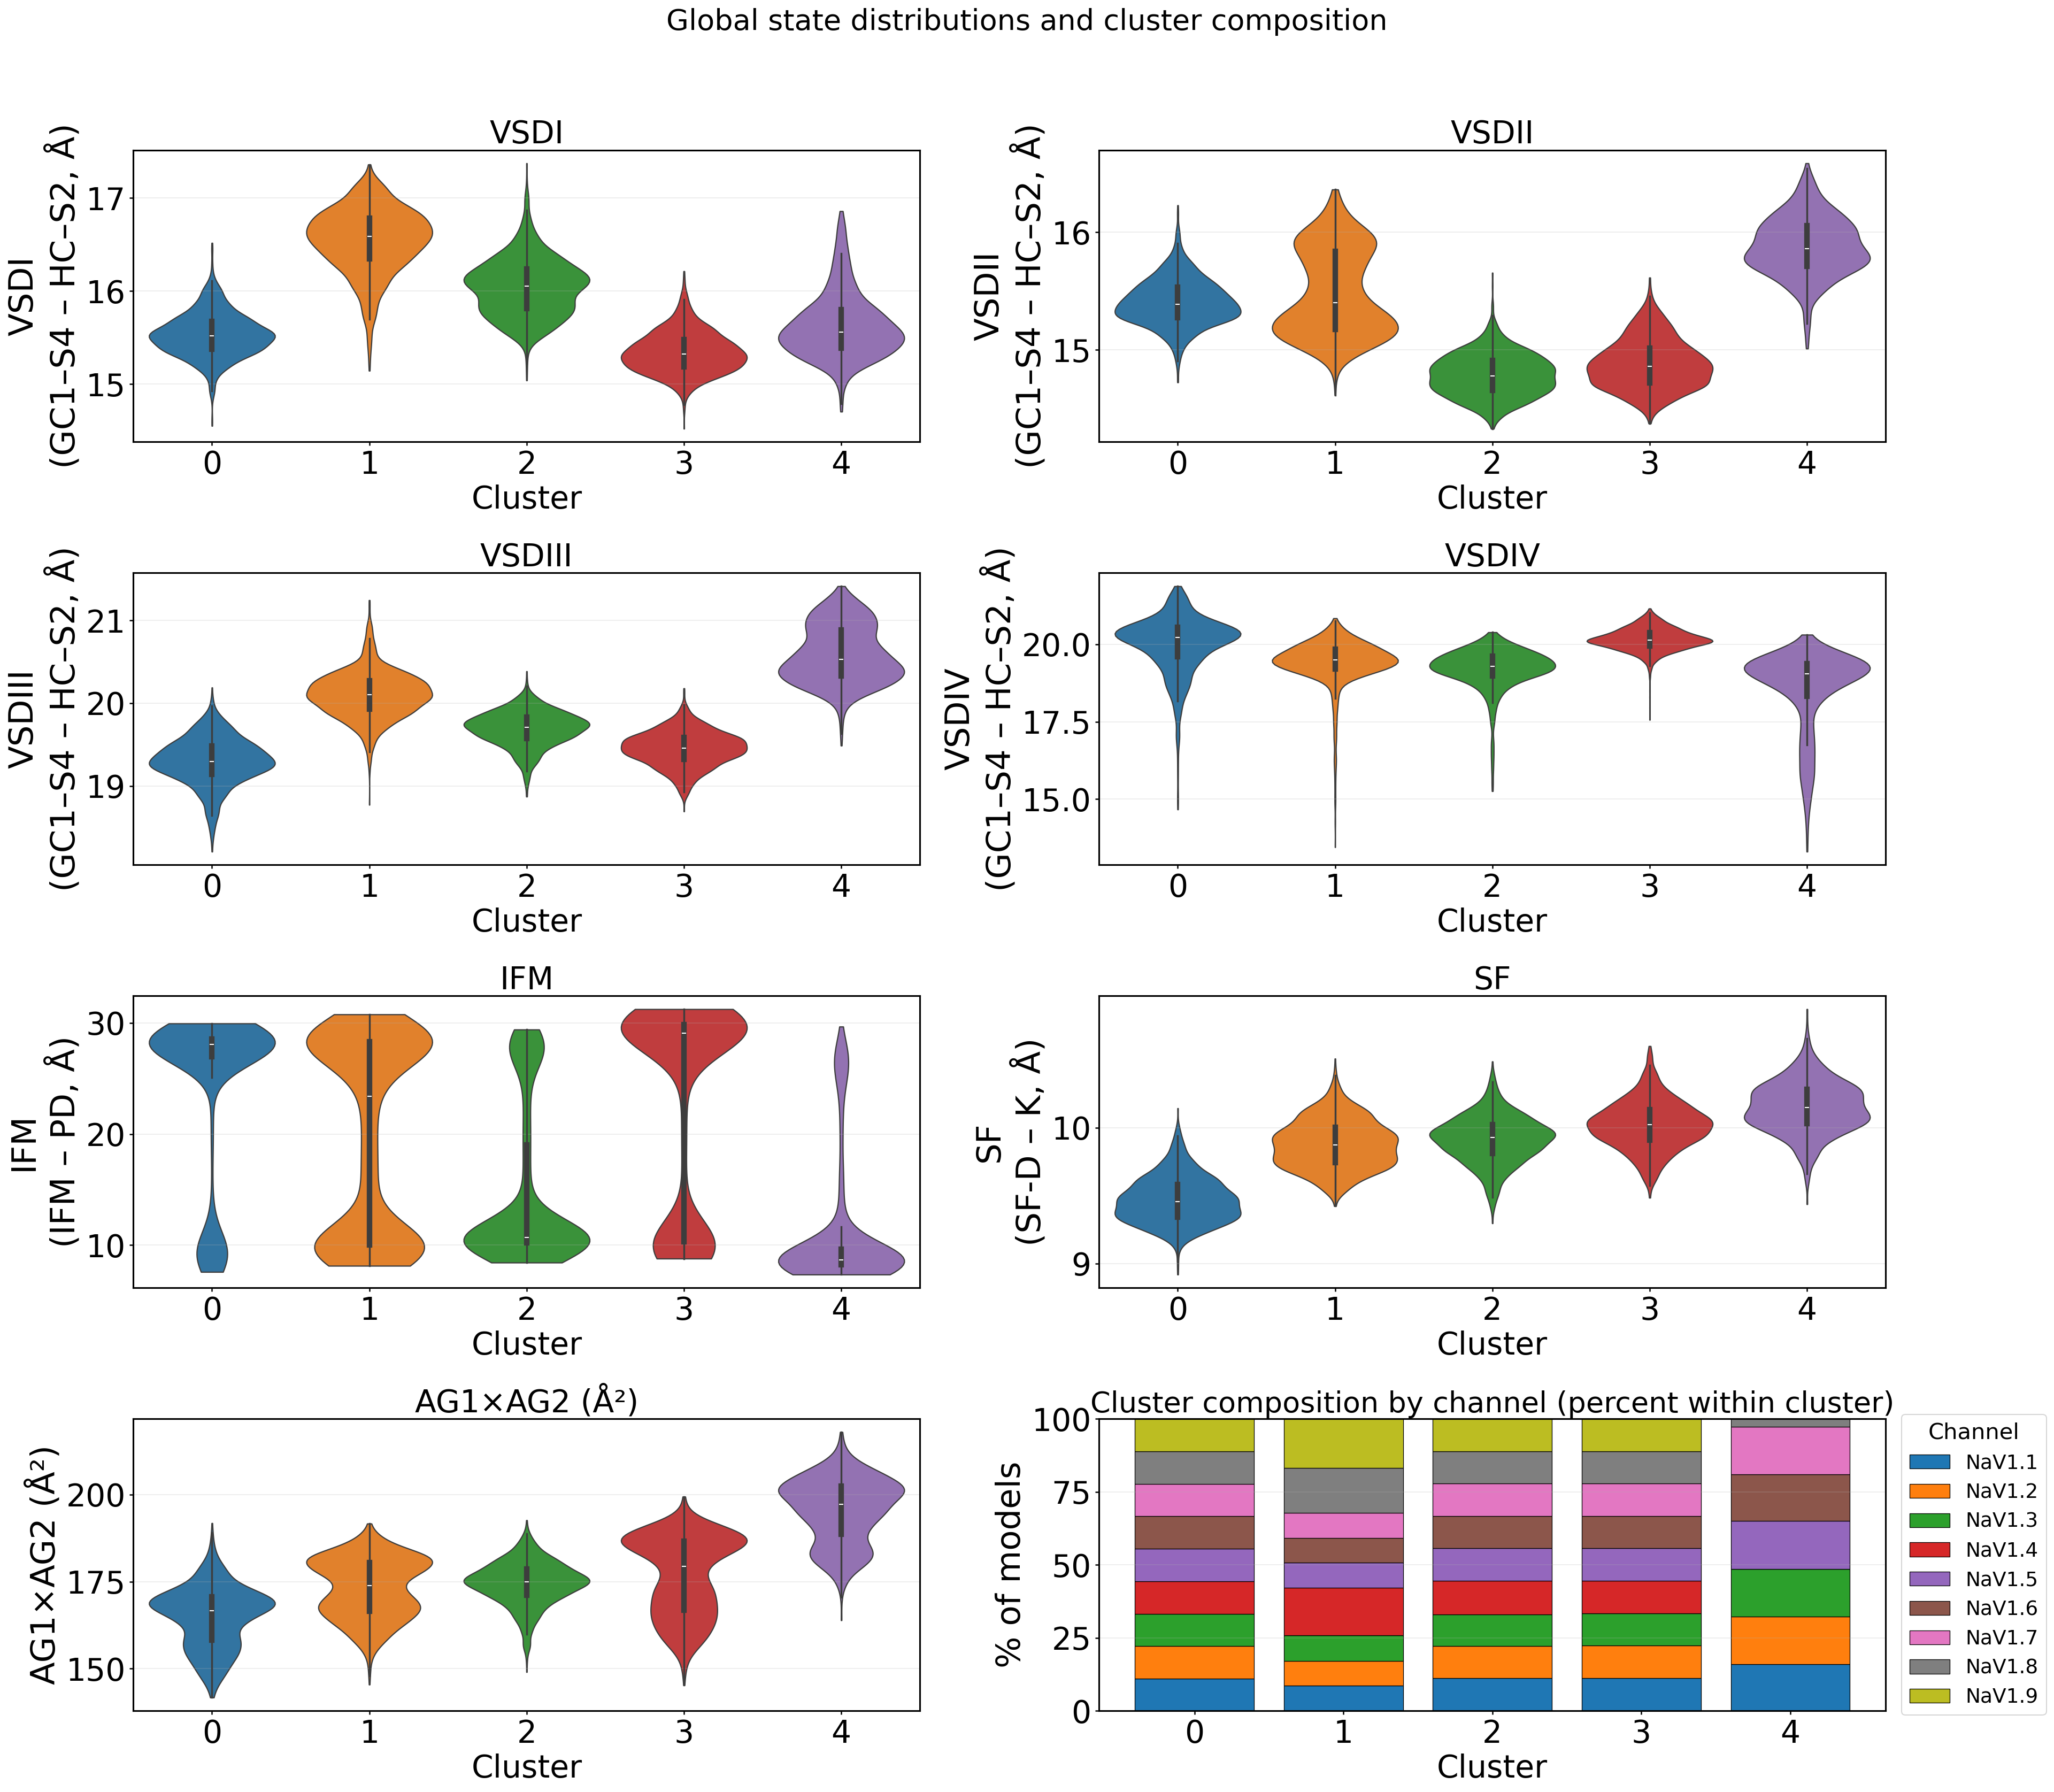


----------------------------------------------------------------------------------------------------
Saved 8-panel summary figure to: /Users/dlopezmateos/Desktop/JGP-Nav-paper/Revision/New-analysis/Analysis1/AlphaOnly/violins_plus_cluster-composition.png
----------------------------------------------------------------------------------------------------


In [6]:
# Ensure the state-like features exist; we’ll derive AG1xAG2
needed = set(["cluster","channel","recycle","AG1","AG2","VSDI","VSDII","VSDIII","VSDIV","IFM","SF"])
missing_any = [c for c in needed if c not in df_all.columns]
if missing_any:
    raise KeyError(f"Missing required columns: {missing_any}")

dfp = df_all.copy()
dfp["AG1xAG2"] = pd.to_numeric(dfp["AG1"], errors="coerce") * pd.to_numeric(dfp["AG2"], errors="coerce")
VIOLIN_FEATURES = ["VSDI","VSDII","VSDIII","VSDIV","IFM","SF","AG1xAG2"]
# Pretty y-axis labels for the violin panels
FEATURE_LABELS = {
    "VSDI"    : "VSDI\n(GC1–S4 – HC–S2, Å)",
    "VSDII"   : "VSDII\n(GC1–S4 – HC–S2, Å)",
    "VSDIII"  : "VSDIII\n(GC1–S4 – HC–S2, Å)",
    "VSDIV"   : "VSDIV\n(GC1–S4 – HC–S2, Å)",
    "IFM"     : "IFM\n(IFM – PD, Å)",
    "SF"      : "SF\n(SF-D – K, Å)",
    # derived product:
    "AG1xAG2" : "AG1×AG2 (Å²)",   # uses Å + superscript 2
}


# Build the big canvas
fig, axes = plt.subplots(4, 2, figsize=(26, 22))   # print-friendly
axes = axes.flatten()

# 1–7: violins (one per feature)
for i, feat in enumerate(VIOLIN_FEATURES):
    ax = axes[i]
    tmp = pd.DataFrame({
        "cluster": dfp["cluster"].astype(int),
        "value": pd.to_numeric(dfp[feat], errors="coerce")
    }).dropna(subset=["value"])
    if tmp.empty:
        ax.axis("off")
        ax.set_title(f"{feat} (no data)", fontsize=20)
        continue

    sns.violinplot(
        data=tmp, x="cluster", y="value",
        order=clusters_sorted,
        palette=[cluster_colors[c] for c in clusters_sorted],
        cut=0, inner="box", linewidth=1.1, ax=ax
    )
    ax.set_xlabel("Cluster", fontsize=28)
    ax.set_ylabel(FEATURE_LABELS.get(feat, feat), fontsize=30)
    ax.set_title(FEATURE_LABELS.get(feat, feat).split("\n")[0], fontsize=28)  # title = feature name only
    ax.tick_params(axis='x', labelsize=28)
    ax.tick_params(axis='y', labelsize=28)
    ax.grid(axis="y", alpha=0.25)

# 8th subplot: bar plot — for each cluster, % composition by channel
palette = sns.color_palette("tab10", n_colors=len(channels_sorted))
channel_colors = dict(zip(channels_sorted, palette))
ax = axes[-1]
comp = (
    dfp.groupby(["cluster","channel"])
       .size()
       .reset_index(name="count")
)

# Normalize to % within each cluster (so bars sum to 100%)
cluster_totals = comp.groupby("cluster")["count"].transform("sum")
comp["pct"] = 100.0 * comp["count"] / cluster_totals

# Ensure plotting order
comp["cluster"] = pd.Categorical(comp["cluster"], categories=clusters_sorted, ordered=True)
comp["channel"] = pd.Categorical(comp["channel"], categories=channels_sorted, ordered=True)

# Stacked bar by cluster
bottom = np.zeros(len(clusters_sorted))
xpos = np.arange(len(clusters_sorted))
for ch in channels_sorted:
    y = comp[comp["channel"]==ch].sort_values("cluster")["pct"].values
    # if a channel is missing in some cluster, align lengths
    if len(y) != len(clusters_sorted):
        # fill missing with zeros
        y_full = np.zeros(len(clusters_sorted))
        cl_to_pct = dict(zip(comp[comp["channel"]==ch]["cluster"], comp[comp["channel"]==ch]["pct"]))
        for j, cl in enumerate(clusters_sorted):
            y_full[j] = cl_to_pct.get(cl, 0.0)
        y = y_full
    ax.bar(xpos, y, bottom=bottom, color=channel_colors[ch], edgecolor="black", linewidth=0.6, label=ch)
    bottom += y

ax.set_xticks(xpos, [str(c) for c in clusters_sorted])
ax.set_xlabel("Cluster", fontsize=28)
ax.set_ylabel("% of models", fontsize=30)
ax.set_title("Cluster composition by channel (percent within cluster)", fontsize=26)
ax.tick_params(axis='x', labelsize=28)
ax.tick_params(axis='y', labelsize=28)
ax.grid(axis="y", alpha=0.25)
ax.legend(title="Channel", bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0., ncol=1)

# Final touches
fig.suptitle("Global state distributions and cluster composition", fontsize=26, y=1.02)
plt.tight_layout()
out_panels = Path("violins_plus_cluster-composition.png")
plt.savefig(out_panels, bbox_inches="tight", dpi=300)
plt.show()

banner(f"Saved 8-panel summary figure to: {out_panels.resolve()}")


/var/folders/yg/k6t1j6jx32x4dnx7sz20k7b40000gr/T/ipykernel_76525/2851209472.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/yg/k6t1j6jx32x4dnx7sz20k7b40000gr/T/ipykernel_76525/2851209472.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/yg/k6t1j6jx32x4dnx7sz20k7b40000gr/T/ipykernel_76525/2851209472.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/yg/k6t1j6jx32x4dnx7sz20k7b40000gr/T/ipykernel_76525/2851209472.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is dep

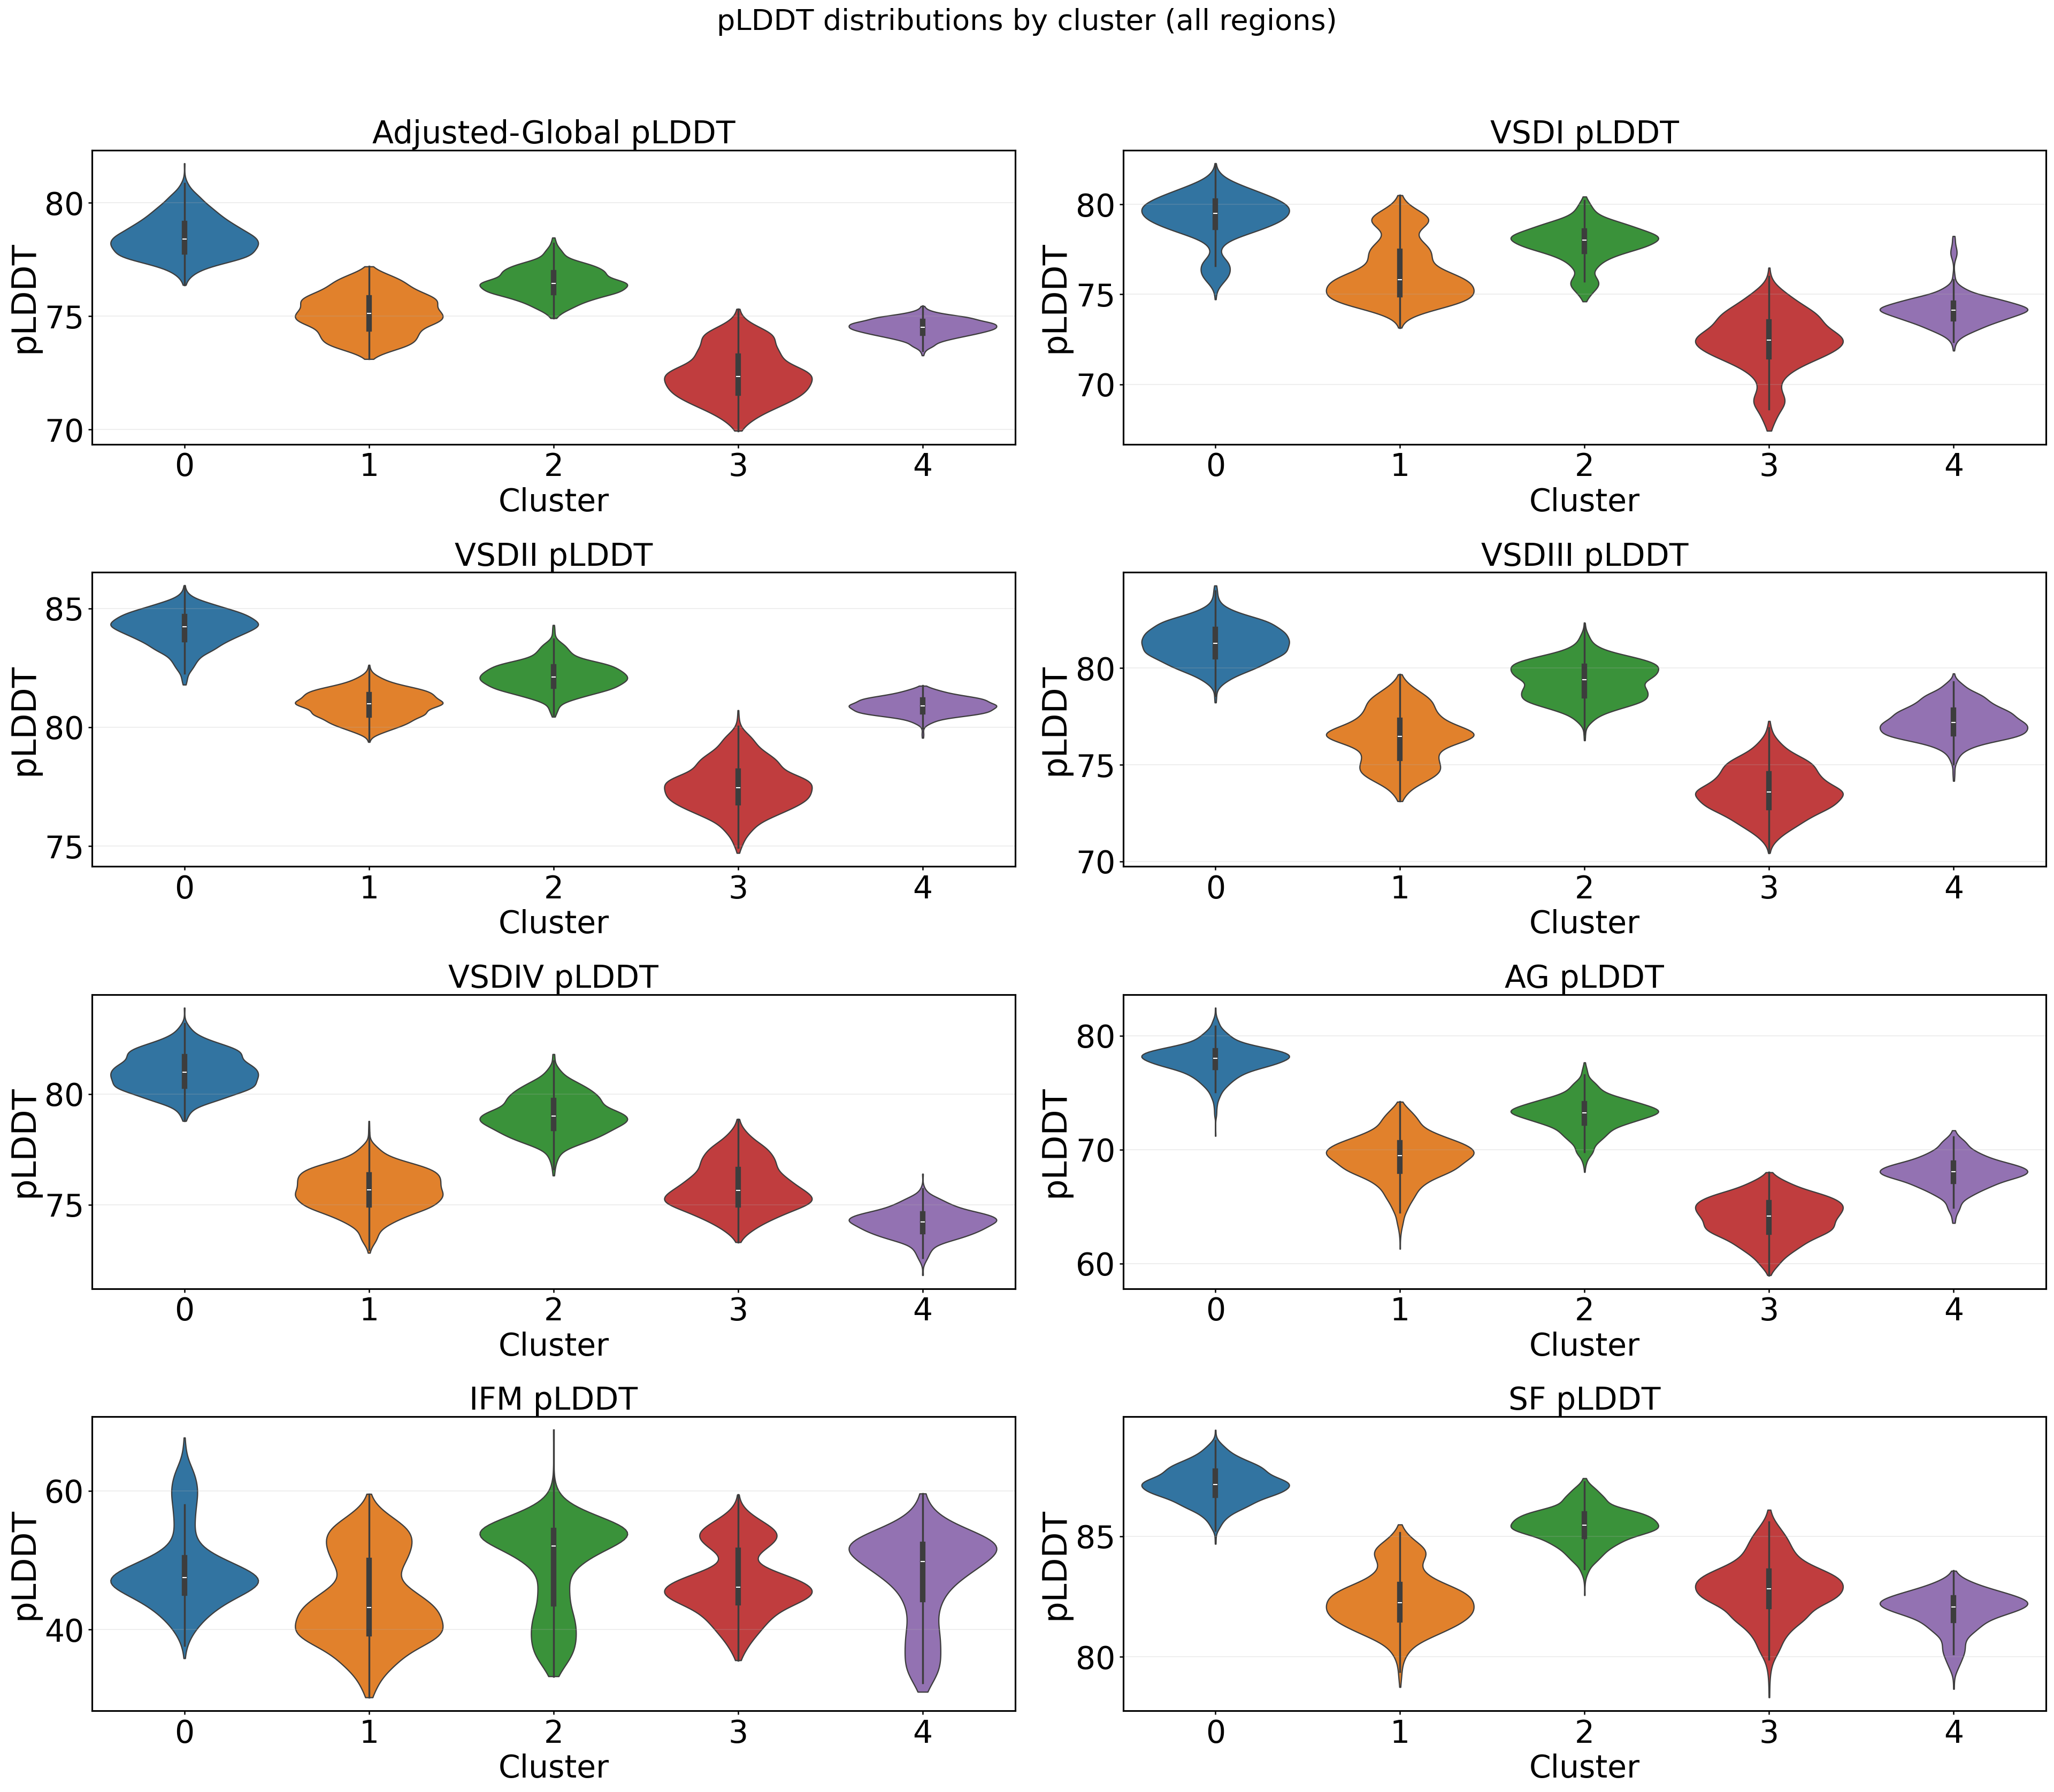


----------------------------------------------------------------------------------------------------
Saved pLDDT violin figure to: /Users/dlopezmateos/Desktop/JGP-Nav-paper/Revision/New-analysis/Analysis1/AlphaOnly/violins_plddt_by_cluster.png
----------------------------------------------------------------------------------------------------


In [7]:
# === pLDDT violins by cluster (8 panels: 4×2) ===
# Uses the same clusters_sorted and cluster_colors as above.

# Ensure pLDDT columns exist
PLDDT_FEATURES = [
    "plddt full", "plddt VSDI", "plddt VSDII", "plddt VSDIII",
    "plddt VSDIV", "plddt AG", "plddt IFM", "plddt SF"
]
missing_plddt = [c for c in PLDDT_FEATURES if c not in df_all.columns]
if missing_plddt:
    raise KeyError(f"Missing pLDDT columns: {missing_plddt}")

# Title mapping for nicer plot labels
title_map = {
    "plddt full": "Adjusted-Global pLDDT",
    "plddt VSDI": "VSDI pLDDT",
    "plddt VSDII": "VSDII pLDDT",
    "plddt VSDIII": "VSDIII pLDDT",
    "plddt VSDIV": "VSDIV pLDDT",
    "plddt AG": "AG pLDDT",
    "plddt IFM": "IFM pLDDT",
    "plddt SF": "SF pLDDT",
}


# Prepare tidy copy
dfp_pl = df_all.copy()
for c in PLDDT_FEATURES:
    dfp_pl[c] = pd.to_numeric(dfp_pl[c], errors="coerce")

# Build the canvas
fig, axes = plt.subplots(4, 2, figsize=(26, 22))   # print-friendly size
axes = axes.flatten()

for i, feat in enumerate(PLDDT_FEATURES):
    ax = axes[i]
    tmp = pd.DataFrame({
        "cluster": dfp_pl["cluster"].astype(int),
        "value": dfp_pl[feat]
    }).dropna(subset=["value"])

    if tmp.empty:
        ax.axis("off")
        ax.set_title(f"{feat} (no data)", fontsize=28)
        continue

    sns.violinplot(
        data=tmp, x="cluster", y="value",
        order=clusters_sorted,
        palette=[cluster_colors[c] for c in clusters_sorted],
        cut=0, inner="box", linewidth=1.1, ax=ax
    )

    ax.set_xlabel("Cluster", fontsize=28)
    ax.set_ylabel("pLDDT", fontsize=30)
    ax.set_title(title_map.get(feat, feat), fontsize=28)
    ax.tick_params(axis='x', labelsize=28)
    ax.tick_params(axis='y', labelsize=28)
    ax.grid(axis="y", alpha=0.25)

fig.suptitle("pLDDT distributions by cluster (all regions)", fontsize=26, y=1.02)
plt.tight_layout()
out_plddt = Path("violins_plddt_by_cluster.png")
plt.savefig(out_plddt, bbox_inches="tight", dpi=300)
plt.show()

banner(f"Saved pLDDT violin figure to: {out_plddt.resolve()}")


In [13]:
# --- Cluster composition summary (robust & safe casting) ---
print("\nCluster composition summary:")

total_models = len(df_all)

summary = (
    df_all.groupby("cluster")
          .size()
          .reset_index(name="Count")
          .sort_values("cluster")
)

summary["Percent"] = 100 * summary["Count"] / total_models

for _, row in summary.iterrows():
    print(f"  Cluster {int(row['cluster']):>2d}: {int(row['Count']):>5d} models ({row['Percent']:.2f}%)")

summary_df = summary.copy()
summary_df


Cluster composition summary:
  Cluster  0:  1078 models (19.96%)
  Cluster  1:  1431 models (26.50%)
  Cluster  2:  1083 models (20.06%)
  Cluster  3:  1080 models (20.00%)
  Cluster  4:   728 models (13.48%)


,cluster,Count,Percent
0,0,1078,19.962963
1,1,1431,26.500000
2,2,1083,20.055556
3,3,1080,20.000000
4,4,728,13.481481
